In [15]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
# Deep Conv Autoencoder Architecture (128x128 RGB)
class HDConvAutoencoder(nn.Module):
    def __init__(self):
        super(HDConvAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),  # [3,128,128] -> [64,64,64]
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# [64,64,64] -> [128,32,32]
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),# [128,32,32] -> [256,16,16]
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), # [256,16,16] -> [128,32,32]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # [128,32,32] -> [64,64,64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),    # [64,64,64] -> [3,128,128]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

#Initialize model, loss, optimizer
model = HDConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
#Load and Preprocess HD Image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # Keeps RGB
])

img_path = "my_img.jpg"  
image = Image.open(img_path).convert("RGB")  # Ensure RGB mode
image = transform(image).unsqueeze(0).to(device)  # Shape: [1, 3, 128, 128]


In [18]:
# Train Autoencoder on One Image (Demo)
epochs = 500  
for epoch in range(epochs):
    output = model(image)
    loss = criterion(output, image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [50/500], Loss: 0.008452
Epoch [100/500], Loss: 0.003623
Epoch [150/500], Loss: 0.002460
Epoch [200/500], Loss: 0.001914
Epoch [250/500], Loss: 0.001540
Epoch [300/500], Loss: 0.001264
Epoch [350/500], Loss: 0.001130
Epoch [400/500], Loss: 0.001092
Epoch [450/500], Loss: 0.000846
Epoch [500/500], Loss: 0.000782


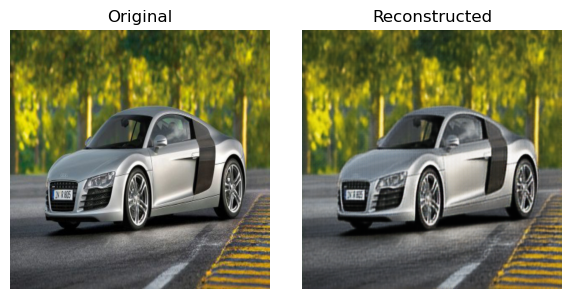

In [19]:
# Show Original vs Reconstructed Image
model.eval()
with torch.no_grad():
    reconstructed = model(image)

# Function to display images
def show_img(tensor_img, title):
    img = tensor_img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Plot original vs. reconstructed images
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
show_img(image, "Original")
plt.subplot(1,2,2)
show_img(reconstructed, "Reconstructed")
plt.tight_layout()
plt.show()
